In [1]:
%cd /kaggle/working

import os

from hydra import compose, initialize
from omegaconf import OmegaConf

with initialize(version_base=None, config_path="../experiments/201_unet_multi/"):
    cfg = compose(
        config_name="config.yaml",
        overrides=["exp=all", "debug=True"],
        return_hydra_config=True,
    )

/kaggle/working


In [2]:
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import polars as pl
import seaborn as sns

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")
pl.Config.set_tbl_cols(-1)
pl.Config.set_tbl_rows(100)

polars.config.Config

In [49]:
def preprocess(df, h):
    tmp = df
    tmp = (
        tmp.with_columns(
            [
                # 1200倍してスケールを揃えておく
                (pl.col(f"ptend_t_{h}") * 1200.0),
                (pl.col(f"ptend_q0001_{h}") * 1200.0),
                (pl.col(f"ptend_q0002_{h}") * 1200.0),
                (pl.col(f"ptend_q0003_{h}") * 1200.0),
            ]
        )
        .with_columns(
            [
                (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}")).alias(
                    f"state_cloud_water_{h}"
                ),
                (pl.col(f"ptend_q0002_{h}") + pl.col(f"ptend_q0003_{h}")).alias(
                    f"ptend_cloud_water_{h}"
                ),
                (pl.col(f"state_t_{h}") + pl.col(f"ptend_t_{h}")).alias(f"new_t_{h}"),
                (pl.col(f"state_q0001_{h}") + pl.col(f"ptend_q0001_{h}"))
                .alias(f"new_q0001_{h}")
                .clip(0),
                (pl.col(f"state_q0002_{h}") + pl.col(f"ptend_q0002_{h}"))
                .alias(f"new_q0002_{h}")
                .clip(0),
                (pl.col(f"state_q0003_{h}") + pl.col(f"ptend_q0003_{h}"))
                .alias(f"new_q0003_{h}")
                .clip(0),
            ]
        )
        .with_columns(
            [
                (
                    pl.col(f"state_cloud_water_{h}") + pl.col(f"ptend_cloud_water_{h}")
                ).alias(f"new_cloud_water_{h}"),
            ]
        )
        .with_columns(
            [
                # 絶対値が元の値の絶対値以下なら０埋めする
                pl.when(
                    pl.col(f"new_cloud_water_{h}").abs()
                    < pl.col(f"ptend_cloud_water_{h}").abs() / 1200
                )
                .then(0)
                .otherwise(pl.col(f"new_cloud_water_{h}"))
                .alias(f"new_cloud_water_{h}"),
                pl.when(
                    pl.col(f"new_q0002_{h}").abs()
                    < pl.col(f"ptend_q0002_{h}").abs() / 1200
                )
                .then(0)
                .otherwise(pl.col(f"new_q0002_{h}"))
                .alias(f"new_q0002_{h}"),
                pl.when(
                    pl.col(f"new_q0003_{h}").abs()
                    < pl.col(f"ptend_q0003_{h}").abs() / 1200
                )
                .then(0)
                .otherwise(pl.col(f"new_q0003_{h}"))
                .alias(f"new_q0003_{h}"),
            ]
        )
        .with_columns(
            [
                (
                    pl.col(f"state_q0002_{h}")
                    / (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}") + 1e-60)
                ).alias("q2_rate"),
                (
                    pl.col(f"new_q0002_{h}")
                    / (pl.col(f"new_q0002_{h}") + pl.col(f"new_q0003_{h}") + 1e-60)
                ).alias("new_q2_rate"),
                (
                    (
                        pl.col(f"ptend_q0002_{h}").abs()
                        + pl.col(f"ptend_q0003_{h}").abs()
                    )
                    / (
                        pl.col(f"state_cloud_water_{h}").abs()
                        + pl.col(f"ptend_q0002_{h}").abs()
                        + pl.col(f"ptend_q0003_{h}").abs()
                        + 1e-60
                    )
                ).alias("change_rate"),
            ]
        )
    )

    cols = [
        f"state_t_{h}",
        f"new_t_{h}",
        "state_ps",
        f"state_cloud_water_{h}",
        f"ptend_cloud_water_{h}",
        f"new_cloud_water_{h}",
        f"state_q0002_{h}",
        f"ptend_q0002_{h}",
        f"new_q0002_{h}",
        f"state_q0003_{h}",
        f"ptend_q0003_{h}",
        f"new_q0003_{h}",
        "q2_rate",
        "new_q2_rate",
        "change_rate",
    ]
    return tmp.select(cols)

In [38]:
exp_name = "201_unet_multi/all"
gcs_path = f"gs://{cfg.dir.gcs_bucket}/{cfg.dir.gcs_base_dir}/experiments/{exp_name}/"
x_df = pl.read_parquet(gcs_path + "val2_original_xs.parquet", retries=5)
predict_df = pl.read_parquet(gcs_path + "val2_predict.parquet", retries=5)
label_df = pl.read_parquet(gcs_path + "val2_label.parquet", retries=5)
columns = pl.read_parquet("input/train.parquet", n_rows=1).columns

In [40]:
x_df.shape, predict_df.shape, label_df.shape

((641280, 557), (641280, 369), (641280, 369))

In [42]:
_x_df = x_df.rename(dict(zip(x_df.columns, columns[:557])))
_predict_df = predict_df[:, 1:].rename(dict(zip(predict_df.columns[1:], columns[557:])))
_label_df = label_df[:, 1:].rename(dict(zip(label_df.columns[1:], columns[557:])))

_x_df.head()

sample_id,state_t_0,state_t_1,state_t_2,state_t_3,state_t_4,state_t_5,state_t_6,state_t_7,state_t_8,state_t_9,state_t_10,state_t_11,state_t_12,state_t_13,state_t_14,state_t_15,state_t_16,state_t_17,state_t_18,state_t_19,state_t_20,state_t_21,state_t_22,state_t_23,state_t_24,state_t_25,state_t_26,state_t_27,state_t_28,state_t_29,state_t_30,state_t_31,state_t_32,state_t_33,state_t_34,state_t_35,state_t_36,state_t_37,state_t_38,state_t_39,state_t_40,state_t_41,state_t_42,state_t_43,state_t_44,state_t_45,state_t_46,state_t_47,state_t_48,state_t_49,state_t_50,state_t_51,state_t_52,state_t_53,state_t_54,state_t_55,state_t_56,state_t_57,state_t_58,state_t_59,state_q0001_0,state_q0001_1,state_q0001_2,state_q0001_3,state_q0001_4,state_q0001_5,state_q0001_6,state_q0001_7,state_q0001_8,state_q0001_9,state_q0001_10,state_q0001_11,state_q0001_12,state_q0001_13,state_q0001_14,state_q0001_15,state_q0001_16,state_q0001_17,state_q0001_18,state_q0001_19,state_q0001_20,state_q0001_21,state_q0001_22,state_q0001_23,state_q0001_24,state_q0001_25,state_q0001_26,state_q0001_27,state_q0001_28,state_q0001_29,state_q0001_30,state_q0001_31,state_q0001_32,state_q0001_33,state_q0001_34,state_q0001_35,state_q0001_36,state_q0001_37,state_q0001_38,state_q0001_39,state_q0001_40,state_q0001_41,state_q0001_42,state_q0001_43,state_q0001_44,state_q0001_45,state_q0001_46,state_q0001_47,state_q0001_48,state_q0001_49,state_q0001_50,state_q0001_51,state_q0001_52,state_q0001_53,state_q0001_54,state_q0001_55,state_q0001_56,state_q0001_57,state_q0001_58,state_q0001_59,state_q0002_0,state_q0002_1,state_q0002_2,state_q0002_3,state_q0002_4,state_q0002_5,state_q0002_6,state_q0002_7,state_q0002_8,state_q0002_9,state_q0002_10,state_q0002_11,state_q0002_12,state_q0002_13,state_q0002_14,state_q0002_15,state_q0002_16,state_q0002_17,state_q0002_18,state_q0002_19,state_q0002_20,state_q0002_21,state_q0002_22,state_q0002_23,state_q0002_24,state_q0002_25,state_q0002_26,state_q0002_27,state_q0002_28,state_q0002_29,state_q0002_30,state_q0002_31,state_q0002_32,state_q0002_33,state_q0002_34,state_q0002_35,state_q0002_36,state_q0002_37,state_q0002_38,state_q0002_39,state_q0002_40,state_q0002_41,state_q0002_42,state_q0002_43,state_q0002_44,state_q0002_45,state_q0002_46,state_q0002_47,state_q0002_48,state_q0002_49,state_q0002_50,state_q0002_51,state_q0002_52,state_q0002_53,state_q0002_54,state_q0002_55,state_q0002_56,state_q0002_57,state_q0002_58,state_q0002_59,state_q0003_0,state_q0003_1,state_q0003_2,state_q0003_3,state_q0003_4,state_q0003_5,state_q0003_6,state_q0003_7,state_q0003_8,state_q0003_9,state_q0003_10,state_q0003_11,state_q0003_12,state_q0003_13,state_q0003_14,state_q0003_15,state_q0003_16,state_q0003_17,state_q0003_18,state_q0003_19,state_q0003_20,state_q0003_21,state_q0003_22,state_q0003_23,state_q0003_24,state_q0003_25,state_q0003_26,state_q0003_27,state_q0003_28,state_q0003_29,state_q0003_30,state_q0003_31,state_q0003_32,state_q0003_33,state_q0003_34,state_q0003_35,state_q0003_36,state_q0003_37,state_q0003_38,state_q0003_39,state_q0003_40,state_q0003_41,state_q0003_42,state_q0003_43,state_q0003_44,state_q0003_45,state_q0003_46,state_q0003_47,state_q0003_48,state_q0003_49,state_q0003_50,state_q0003_51,state_q0003_52,state_q0003_53,state_q0003_54,state_q0003_55,state_q0003_56,state_q0003_57,state_q0003_58,state_q0003_59,state_u_0,state_u_1,state_u_2,state_u_3,state_u_4,state_u_5,state_u_6,state_u_7,state_u_8,state_u_9,state_u_10,state_u_11,state_u_12,state_u_13,state_u_14,state_u_15,state_u_16,state_u_17,state_u_18,state_u_19,state_u_20,state_u_21,state_u_22,state_u_23,state_u_24,state_u_25,state_u_26,state_u_27,state_u_28,state_u_29,state_u_30,state_u_31,state_u_32,state_u_33,state_u_34,state_u_35,state_u_36,state_u_37,state_u_38,state_u_39,state_u_40,state_u_41,state_u_42,state_u_43,state_u_44,state_u_45,state_u_46,state_u_47,state_u_48,state_u_49,state_u_50,state_u_51,state_u_52,state_u_53,state_u_54,state_u_55,state_u_56,state_u_57,state_u_58,state_u_59,state_v_0,state_v_1,

In [43]:
df = pl.concat([_x_df, _predict_df], how="horizontal")
df.shape

(641280, 925)

(641280, 15)


/tmp/ipykernel_4576/2686309953.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


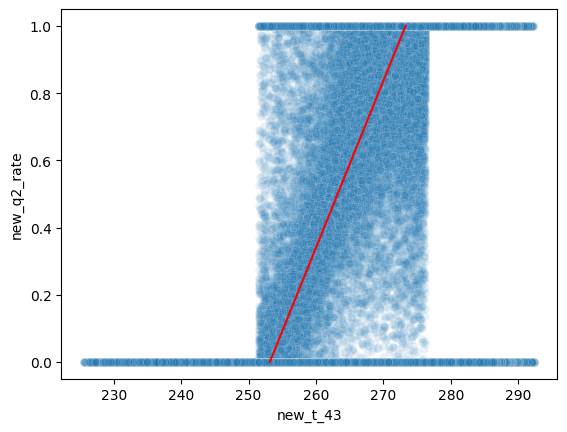

In [54]:
df = pl.concat([_x_df, _predict_df], how="horizontal")

h = 43
tmp = preprocess(df, h)
print(tmp.shape)

sns.scatterplot(
    data=tmp.filter(pl.col("change_rate") > 0.4).to_pandas(),
    x=f"new_t_{h}",
    y=f"new_q2_rate",
    palette="red",
    alpha=0.1,
)
plt.plot([253.15, 273.28], [0, 1.0], color="red", linestyle="-")
plt.show()

/tmp/ipykernel_4576/1592715643.py:7: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(


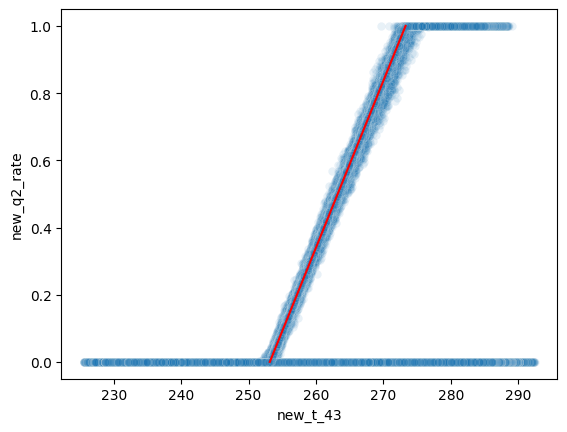

In [46]:
df = pl.concat([_x_df, _label_df], how="horizontal")

h = 43
tmp = preprocess(df, h)


sns.scatterplot(
    data=tmp.to_pandas(),
    x=f"new_t_{h}",
    y=f"new_q2_rate",
    palette="red",
    alpha=0.1,
)
plt.plot([253.15, 273.28], [0, 1.0], color="red", linestyle="-")
plt.show()

In [37]:
df.shape

(641280, 923)

## 全hについてtmelt, tice をざっくり計算

In [4]:
tmelt_list = []
tice_list = []


for h in range(60):
    tmp = df
    tmp = (
        tmp.with_columns(
            [
                # 1200倍してスケールを揃えておく
                (pl.col(f"ptend_t_{h}") * 1200.0),
                (pl.col(f"ptend_q0001_{h}") * 1200.0),
                (pl.col(f"ptend_q0002_{h}") * 1200.0),
                (pl.col(f"ptend_q0003_{h}") * 1200.0),
            ]
        )
        .with_columns(
            [
                (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}")).alias(
                    f"state_cloud_water_{h}"
                ),
                (pl.col(f"ptend_q0002_{h}") + pl.col(f"ptend_q0003_{h}")).alias(
                    f"ptend_cloud_water_{h}"
                ),
                (pl.col(f"state_t_{h}") + pl.col(f"ptend_t_{h}")).alias(f"new_t_{h}"),
                (pl.col(f"state_q0001_{h}") + pl.col(f"ptend_q0001_{h}")).alias(
                    f"new_q0001_{h}"
                ),
                (pl.col(f"state_q0002_{h}") + pl.col(f"ptend_q0002_{h}")).alias(
                    f"new_q0002_{h}"
                ),
                (pl.col(f"state_q0003_{h}") + pl.col(f"ptend_q0003_{h}")).alias(
                    f"new_q0003_{h}"
                ),
            ]
        )
        .with_columns(
            [
                (
                    pl.col(f"state_cloud_water_{h}") + pl.col(f"ptend_cloud_water_{h}")
                ).alias(f"new_cloud_water_{h}"),
            ]
        )
        .with_columns(
            [
                # 絶対値が元の値の絶対値以下なら０埋めする
                pl.when(
                    pl.col(f"new_cloud_water_{h}").abs()
                    < pl.col(f"ptend_cloud_water_{h}").abs() / 1200
                )
                .then(0)
                .otherwise(pl.col(f"new_cloud_water_{h}"))
                .alias(f"new_cloud_water_{h}"),
                pl.when(
                    pl.col(f"new_q0002_{h}").abs()
                    < pl.col(f"ptend_q0002_{h}").abs() / 1200
                )
                .then(0)
                .otherwise(pl.col(f"new_q0002_{h}"))
                .alias(f"new_q0002_{h}"),
                pl.when(
                    pl.col(f"new_q0003_{h}").abs()
                    < pl.col(f"ptend_q0003_{h}").abs() / 1200
                )
                .then(0)
                .otherwise(pl.col(f"new_q0003_{h}"))
                .alias(f"new_q0003_{h}"),
            ]
        )
        .with_columns(
            [
                (
                    pl.col(f"state_q0003_{h}")
                    / (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}") + 1e-60)
                ).alias("state_ice_ratio"),
                (
                    pl.col(f"ptend_q0003_{h}")
                    / (pl.col(f"ptend_q0002_{h}") + pl.col(f"ptend_q0003_{h}") + 1e-60)
                ).alias("ptend_ice_ratio"),
                (
                    pl.col(f"new_q0003_{h}")
                    / (pl.col(f"new_q0002_{h}") + pl.col(f"new_q0003_{h}") + 1e-60)
                ).alias("new_state_ice_ratio"),
            ]
        )
    )

    cols = [
        f"state_t_{h}",
        f"new_t_{h}",
        "state_ps",
        f"state_cloud_water_{h}",
        f"ptend_cloud_water_{h}",
        f"new_cloud_water_{h}",
        f"state_q0002_{h}",
        f"ptend_q0002_{h}",
        f"new_q0002_{h}",
        f"state_q0003_{h}",
        f"ptend_q0003_{h}",
        f"new_q0003_{h}",
        "state_ice_ratio",
        "ptend_ice_ratio",
        "new_state_ice_ratio",
    ]

    zero_cld_water = len(tmp[cols].filter((pl.col(f"new_cloud_water_{h}") == 0)))
    zero_q2 = len(
        tmp[cols].filter(
            (pl.col(f"new_cloud_water_{h}") != 0) & (pl.col(f"new_q0002_{h}") == 0)
        )
    )
    zero_q3 = len(
        tmp[cols].filter(
            (pl.col(f"new_cloud_water_{h}") != 0) & (pl.col(f"new_q0003_{h}") == 0)
        )
    )
    df4 = tmp[cols].filter(
        (pl.col(f"new_cloud_water_{h}") != 0)
        & (pl.col(f"new_q0002_{h}") != 0)
        & (pl.col(f"new_q0003_{h}") != 0)
    )
    print(
        h,
        f"{zero_cld_water=} {zero_q2=} {zero_q3=}",
        df4.shape,
        df4[f"new_t_{h}"].min(),
        df4[f"new_t_{h}"].max(),
    )

0 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 181.25664719139135 239.683546617858
1 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 194.37762095615687 256.9830665948285
2 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 218.8272232346663 268.33997894647035
3 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 230.35235059733665 268.16776741827744
4 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 230.61573832471353 277.0459857210883
5 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 227.08428223789394 281.92504490482287
6 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 215.72699060547794 285.23358625739314
7 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 207.07657082040546 277.6429670436622
8 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 199.78579950073222 260.6832303006824
9 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 194.7071126952218 247.53472101495026
10 zero_cld_water=0 zero_q2=0 zero_q3=0 (10000, 15) 192.09202371013214 241.5887072313646
11 zero_cld_water=0 zero_q2=0

In [9]:
tmelt_array = np.array(tmelt_list)
tice_array = np.array(tice_list)

tmelt_array, tice_array

(array([274.6452439409149, 268.81336854354106, 282.8836136190508,
        292.8672854964376, 284.2530073870298, 288.89618073747914,
        289.4136832706837, 282.0638136190683, 273.35167682234294,
        266.6118764885425, 259.0867475792356, 251.28594196730964, None,
        None, None, None, None, None, None, None, None, None, None, None,
        None, None, None, None, None, 253.39545356829237,
        256.7823846214321, 259.9661526368073, 262.84940812777177,
        265.8623916576089, 268.3820074087884, 270.5757194179083,
        272.95781155994763, 274.9919665834025, 276.162484208296,
        276.6020970521915, 276.37702916552973, 277.5791145799715,
        276.55258081192227, 275.9767573624635, 275.4432248389637,
        275.67857618817914, 275.21762752675716, 275.4177395926,
        275.1971389885452, 274.56423677841985, 274.4653563416054,
        274.3710918600397, 274.43999088130465, 274.6935739481715,
        274.812597125582, 275.4026175208636, 275.49756113171924,
        2

## 変化量そのものを確認

In [59]:
h = 40
tmp = df

tmp = tmp.with_columns(
    [
        (pl.col(f"state_t_{h}") + 1200.0 * pl.col(f"ptend_t_{h}")).alias(f"new_t_{h}"),
        (pl.col(f"ptend_q0001_{h}") * 1200.0),
        (pl.col(f"ptend_q0002_{h}") * 1200.0),
        (pl.col(f"ptend_q0003_{h}") * 1200.0),
        (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}")).alias(
            f"state_cloud_water_{h}"
        ),
        (pl.col(f"ptend_q0002_{h}") + pl.col(f"ptend_q0003_{h}")).alias(
            f"ptend_cloud_water_{h}"
        ),
        (
            pl.col(f"state_q0003_{h}")
            / (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}") + 1e-60)
        ).alias("state_ice_ratio"),
        (
            pl.col(f"ptend_q0003_{h}")
            / (pl.col(f"ptend_q0002_{h}") + pl.col(f"ptend_q0003_{h}") + 1e-60)
        ).alias("ptend_ice_ratio"),
    ]
)

cols = [
    f"state_t_{h}",
    f"new_t_{h}",
    f"state_q0001_{h}",
    f"ptend_q0001_{h}",
    f"state_cloud_water_{h}",
    f"ptend_cloud_water_{h}",
    f"state_q0002_{h}",
    f"ptend_q0002_{h}",
    f"state_q0003_{h}",
    f"ptend_q0003_{h}",
    "state_ice_ratio",
    "ptend_ice_ratio",
]

tmp[cols].head()

state_t_40,new_t_40,state_q0001_40,ptend_q0001_40,state_cloud_water_40,ptend_cloud_water_40,state_q0002_40,ptend_q0002_40,state_q0003_40,ptend_q0003_40,state_ice_ratio,ptend_ice_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
273.809924,273.781051,0.001845,-0.000002,7.5343e-8,-6.2786e-11,3.5920e-8,-3.5920e-8,3.9423e-8,-3.9423e-8,0.523242,0.523242
270.031305,269.996256,0.001441,0.000002,0.000002,-1.5434e-9,9.1013e-7,-9.1013e-7,9.4192e-7,-9.4192e-7,0.508581,0.508581
277.506678,277.486619,0.003403,0.000014,3.3294e-7,-2.7745e-10,3.3294e-7,-3.3294e-7,0.0,0.0,0.0,-0.0
277.292413,277.26869,0.003594,-0.000013,0.000004,-3.2619e-9,0.000004,-0.000004,0.0,0.0,0.0,-0.0
266.889962,266.853093,0.001652,0.000005,0.000003,-2.4003e-9,0.000001,-0.000001,0.000002,-0.000002,0.60542,0.60542


In [60]:
max_tmp = 273.28
min_tmp = 253.15

In [61]:
tmp[cols].with_columns(
    ((max_tmp - pl.col(f"state_t_{h}")) / (max_tmp - min_tmp)).alias("theory_ratio")
)

state_t_40,new_t_40,state_q0001_40,ptend_q0001_40,state_cloud_water_40,ptend_cloud_water_40,state_q0002_40,ptend_q0002_40,state_q0003_40,ptend_q0003_40,state_ice_ratio,ptend_ice_ratio,theory_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
273.809924,273.781051,0.001845,-0.000002,7.5343e-8,-6.2786e-11,3.5920e-8,-3.5920e-8,3.9423e-8,-3.9423e-8,0.523242,0.523242,-0.026325
270.031305,269.996256,0.001441,0.000002,0.000002,-1.5434e-9,9.1013e-7,-9.1013e-7,9.4192e-7,-9.4192e-7,0.508581,0.508581,0.161386
277.506678,277.486619,0.003403,0.000014,3.3294e-7,-2.7745e-10,3.3294e-7,-3.3294e-7,0.0,0.0,0.0,-0.0,-0.209969
277.292413,277.26869,0.003594,-0.000013,0.000004,-3.2619e-9,0.000004,-0.000004,0.0,0.0,0.0,-0.0,-0.199325
266.889962,266.853093,0.001652,0.000005,0.000003,-2.4003e-9,0.000001,-0.000001,0.000002,-0.000002,0.60542,0.60542,0.317439
267.151113,267.143804,0.003568,0.000008,0.00004,5.3431e-9,0.000029,0.000003,0.000011,0.000004,0.266555,0.575264,0.304465
275.533635,275.620951,0.006508,-9.5187e-7,0.000021,1.3566e-9,0.000021,0.000002,1.5481e-8,-1.5481e-8,0.000724,-0.00951,-0.111954
275.388406,275.455323,0.006545,0.000033,0.000031,1.4591e-8,0.000031,0.000018,5.9807e-7,-5.9807e-7,0.0192,-0.034159,-0.104739
270.691832,270.800804,0.004939,-0.000048,0.000194,4.1048e-8,0.000171,0.000043,0.000023,0.000006,0.116168,0.124689,0.128573


In [68]:
tmp[cols].filter(
    (pl.col(f"ptend_q0002_{h}") < 0)
    & (pl.col(f"ptend_q0003_{h}") > 0)
    & ((pl.col(f"state_q0002_{h}") + pl.col(f"ptend_q0002_{h}")).abs() > 1e-20)
).head(50).sort("state_t_40")

state_t_40,new_t_40,state_q0001_40,ptend_q0001_40,state_cloud_water_40,ptend_cloud_water_40,state_q0002_40,ptend_q0002_40,state_q0003_40,ptend_q0003_40,state_ice_ratio,ptend_ice_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
252.73381,252.791539,0.000852,0.000017,0.000019,1.6179e-8,2.6815e-7,-1.4406e-7,0.000019,0.00002,0.985869,1.00742
253.060034,253.056661,0.000891,-0.000002,0.000022,4.8259e-9,1.2435e-7,-1.0009e-7,0.000022,0.000006,0.994338,1.017284
253.159907,253.249637,0.00104,-0.000021,0.000071,8.6355e-9,8.2312e-7,-5.8448e-7,0.000071,0.000011,0.988482,1.056404
253.295862,253.283616,0.000979,0.000004,0.000019,-2.6649e-10,0.000002,-0.000002,0.000017,0.000002,0.894054,-4.983824
253.315254,253.345578,0.000521,-0.000009,0.000021,6.0184e-10,0.000001,-6.0443e-7,0.00002,0.000001,0.934015,1.836927
253.388558,253.384227,0.000911,-0.000002,0.000022,4.6485e-9,4.1630e-7,-1.8321e-7,0.000021,0.000006,0.980973,1.032845
253.51822,253.586236,0.001075,-0.000026,0.000078,3.0690e-9,0.000003,-0.000001,0.000075,0.000005,0.966443,1.284253
253.632671,253.616735,0.000947,0.00001,0.000037,4.9731e-9,0.000001,-1.8881e-7,0.000036,0.000006,0.967185,1.031638
253.651902,253.75793,0.00109,-0.000021,0.000091,5.6766e-9,0.000004,-8.4433e-7,0.000087,0.000008,0.951429,1.12395


## 変化量を足して変化後の値を元に検証

In [4]:
tmelt = 273.15

tmax_fice = tmelt - 10.0  #! max temperature for cloud ice formation
tmin_fice = tmax_fice - 30.0  #! min temperature for cloud ice formation
tmax_fsnow = tmelt  #! max temperature for transition to convective snow
tmin_fsnow = tmelt - 5.0  #! min temperature for transition to convective snow

In [58]:
h = 40

tmp = df
tmp = (
    tmp.with_columns(
        [
            # 1200倍してスケールを揃えておく
            (pl.col(f"ptend_t_{h}") * 1200.0),
            (pl.col(f"ptend_q0001_{h}") * 1200.0),
            (pl.col(f"ptend_q0002_{h}") * 1200.0),
            (pl.col(f"ptend_q0003_{h}") * 1200.0),
        ]
    )
    .with_columns(
        [
            (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}")).alias(
                f"state_cloud_water_{h}"
            ),
            (pl.col(f"ptend_q0002_{h}") + pl.col(f"ptend_q0003_{h}")).alias(
                f"ptend_cloud_water_{h}"
            ),
            (pl.col(f"state_t_{h}") + pl.col(f"ptend_t_{h}")).alias(f"new_t_{h}"),
            (pl.col(f"state_q0001_{h}") + pl.col(f"ptend_q0001_{h}")).alias(
                f"new_q0001_{h}"
            ),
            (pl.col(f"state_q0002_{h}") + pl.col(f"ptend_q0002_{h}")).alias(
                f"new_q0002_{h}"
            ),
            (pl.col(f"state_q0003_{h}") + pl.col(f"ptend_q0003_{h}")).alias(
                f"new_q0003_{h}"
            ),
        ]
    )
    .with_columns(
        [
            (pl.col(f"state_cloud_water_{h}") + pl.col(f"ptend_cloud_water_{h}")).alias(
                f"new_cloud_water_{h}"
            ),
        ]
    )
    .with_columns(
        [
            # 絶対値が元の値の絶対値以下なら０埋めする
            pl.when(
                pl.col(f"new_cloud_water_{h}").abs()
                < pl.col(f"ptend_cloud_water_{h}").abs() / 1200
            )
            .then(0)
            .otherwise(pl.col(f"new_cloud_water_{h}"))
            .alias(f"new_cloud_water_{h}"),
            pl.when(
                pl.col(f"new_q0002_{h}").abs() < pl.col(f"ptend_q0002_{h}").abs() / 1200
            )
            .then(0)
            .otherwise(pl.col(f"new_q0002_{h}"))
            .alias(f"new_q0002_{h}"),
            pl.when(
                pl.col(f"new_q0003_{h}").abs() < pl.col(f"ptend_q0003_{h}").abs() / 1200
            )
            .then(0)
            .otherwise(pl.col(f"new_q0003_{h}"))
            .alias(f"new_q0003_{h}"),
        ]
    )
    .with_columns(
        [
            (
                pl.col(f"state_q0003_{h}")
                / (pl.col(f"state_q0002_{h}") + pl.col(f"state_q0003_{h}") + 1e-60)
            ).alias("state_ice_ratio"),
            (
                pl.col(f"ptend_q0003_{h}")
                / (pl.col(f"ptend_q0002_{h}") + pl.col(f"ptend_q0003_{h}") + 1e-60)
            ).alias("ptend_ice_ratio"),
            (
                pl.col(f"new_q0003_{h}")
                / (pl.col(f"new_q0002_{h}") + pl.col(f"new_q0003_{h}") + 1e-60)
            ).alias("new_state_ice_ratio"),
        ]
    )
)

cols = [
    f"state_t_{h}",
    f"state_ps",
    f"state_cloud_water_{h}",
    f"ptend_cloud_water_{h}",
    f"new_cloud_water_{h}",
    f"state_q0002_{h}",
    f"ptend_q0002_{h}",
    f"new_q0002_{h}",
    f"state_q0003_{h}",
    f"ptend_q0003_{h}",
    f"new_q0003_{h}",
    "state_ice_ratio",
    "ptend_ice_ratio",
    "new_state_ice_ratio",
]

tmp[cols].head()

state_t_40,state_ps,state_cloud_water_40,ptend_cloud_water_40,new_cloud_water_40,state_q0002_40,ptend_q0002_40,new_q0002_40,state_q0003_40,ptend_q0003_40,new_q0003_40,state_ice_ratio,ptend_ice_ratio,new_state_ice_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
273.809924,101135.616333,7.5343e-8,-7.5343e-8,0.0,3.5920e-8,-3.5920e-8,0.0,3.9423e-8,-3.9423e-8,0.0,0.523242,0.523242,0.0
270.031305,101427.583863,0.000002,-0.000002,0.0,9.1013e-7,-9.1013e-7,0.0,9.4192e-7,-9.4192e-7,0.0,0.508581,0.508581,0.0
277.506678,99069.424153,3.3294e-7,-3.3294e-7,0.0,3.3294e-7,-3.3294e-7,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
277.292413,100786.588229,0.000004,-0.000004,0.0,0.000004,-0.000004,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
266.889962,101229.487373,0.000003,-0.000003,0.0,0.000001,-0.000001,0.0,0.000002,-0.000002,0.0,0.60542,0.60542,0.0


In [59]:
# 1. new cloud water が 0 の時を見る -> state_ice_ratio と ptend_ice_ratioがほぼ一致（すべて０に潰れるから）
df1 = tmp[cols].filter(pl.col(f"new_cloud_water_{h}") == 0)
print(
    df1.shape, ((df1["state_ice_ratio"] - df1["ptend_ice_ratio"]).abs() < 1e-15).sum()
)
df1

(51861, 14) 51838


state_t_40,state_ps,state_cloud_water_40,ptend_cloud_water_40,new_cloud_water_40,state_q0002_40,ptend_q0002_40,new_q0002_40,state_q0003_40,ptend_q0003_40,new_q0003_40,state_ice_ratio,ptend_ice_ratio,new_state_ice_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
273.809924,101135.616333,7.5343e-8,-7.5343e-8,0.0,3.5920e-8,-3.5920e-8,0.0,3.9423e-8,-3.9423e-8,0.0,0.523242,0.523242,0.0
270.031305,101427.583863,0.000002,-0.000002,0.0,9.1013e-7,-9.1013e-7,0.0,9.4192e-7,-9.4192e-7,0.0,0.508581,0.508581,0.0
277.506678,99069.424153,3.3294e-7,-3.3294e-7,0.0,3.3294e-7,-3.3294e-7,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
277.292413,100786.588229,0.000004,-0.000004,0.0,0.000004,-0.000004,0.0,0.0,0.0,0.0,0.0,-0.0,0.0
266.889962,101229.487373,0.000003,-0.000003,0.0,0.000001,-0.000001,0.0,0.000002,-0.000002,0.0,0.60542,0.60542,0.0
276.049222,100269.519172,0.000011,-0.000011,0.0,0.000011,-0.000011,0.0,5.7279e-7,-5.7279e-7,0.0,0.050939,0.050939,0.0
274.608047,96133.193676,0.000001,-0.000001,0.0,0.000001,-0.000001,0.0,1.0571e-7,-1.0571e-7,0.0,0.071545,0.071545,0.0
270.836799,99229.436989,1.7041e-7,-1.7041e-7,0.0,9.9378e-8,-9.9378e-8,0.0,7.1027e-8,-7.1027e-8,0.0,0.416812,0.416812,0.0
271.302744,100362.575258,7.6271e-7,-7.6271e-7,0.0,6.8987e-7,-6.8987e-7,0.0,7.2844e-8,-7.2844e-8,0.0,0.095507,0.095507,0.0


In [60]:
# 2. new cloud water が 0 以外の時を見る. 温度が高く ice がすべてなくなるケース
df2 = (
    tmp[cols]
    .filter((pl.col(f"new_cloud_water_{h}") != 0) & (pl.col(f"new_q0003_{h}") == 0))
    .sort(f"state_t_{h}")
)
print(df2.shape, df2[f"state_t_{h}"].min())

df2

(13088, 14) 272.49257432194673


state_t_40,state_ps,state_cloud_water_40,ptend_cloud_water_40,new_cloud_water_40,state_q0002_40,ptend_q0002_40,new_q0002_40,state_q0003_40,ptend_q0003_40,new_q0003_40,state_ice_ratio,ptend_ice_ratio,new_state_ice_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
272.492574,102078.792734,0.000015,0.000006,0.000021,0.000014,0.000007,0.000021,6.9267e-7,-6.9267e-7,0.0,0.045908,-0.113392,0.0
272.554054,101919.47541,0.000002,0.000027,0.000028,5.6315e-7,0.000028,0.000028,0.000001,-0.000001,0.0,0.683866,-0.045715,0.0
272.629656,98653.458048,0.000026,0.000011,0.000037,0.000026,0.000012,0.000037,1.4465e-7,-1.4465e-7,0.0,0.005617,-0.01272,0.0
272.713562,102032.967,0.000004,0.00003,0.000035,0.000004,0.000031,0.000035,9.9807e-8,-9.9807e-8,0.0,0.024334,-0.003283,0.0
272.730468,102585.364233,0.000016,0.000012,0.000028,0.000016,0.000012,0.000028,1.1099e-7,-1.1099e-7,0.0,0.006851,-0.009179,0.0
272.745464,101722.101771,0.000018,0.000004,0.000022,0.000018,0.000004,0.000022,0.0,0.0,0.0,0.0,0.0,0.0
272.79472,98573.579624,0.000001,0.000029,0.00003,0.000001,0.000029,0.00003,2.1592e-8,-2.1592e-8,0.0,0.014693,-0.000751,0.0
272.830531,98800.792281,0.000011,0.00002,0.00003,0.00001,0.00002,0.00003,2.0436e-7,-2.0436e-7,0.0,0.019246,-0.010387,0.0
273.031886,98949.487641,0.000023,-0.000016,0.000008,0.000023,-0.000015,0.000008,5.1103e-7,-5.1103e-7,0.0,0.021824,0.032938,0.0


In [61]:
# 3. new cloud water が 0 以外の時を見る. 温度が低く water がすべてなくなるケース
df3 = (
    tmp[cols]
    .filter((pl.col(f"new_cloud_water_{h}") != 0) & (pl.col(f"new_q0002_{h}") == 0))
    .sort(f"state_t_{h}", descending=True)
)
print(df3.shape, df3[f"state_t_{h}"].max())

df3

(14341, 14) 259.54974583252516


state_t_40,state_ps,state_cloud_water_40,ptend_cloud_water_40,new_cloud_water_40,state_q0002_40,ptend_q0002_40,new_q0002_40,state_q0003_40,ptend_q0003_40,new_q0003_40,state_ice_ratio,ptend_ice_ratio,new_state_ice_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
259.549746,99999.311243,0.000007,-0.000007,6.6724e-9,0.000004,-0.000004,0.0,0.000003,-0.000003,4.6935e-9,0.473213,0.472998,1.0
257.790965,100367.651632,0.000007,-0.000007,6.2354e-9,0.000002,-0.000002,0.0,0.000004,-0.000004,4.8573e-9,0.638712,0.63858,1.0
256.662485,90428.762384,0.000005,-0.000005,1.3518e-8,0.000002,-0.000002,0.0,0.000003,-0.000003,1.1866e-8,0.57342,0.572567,1.0
255.222875,100573.079799,0.000013,-0.000013,3.6499e-8,0.000008,-0.000008,0.0,0.000005,-0.000005,3.3502e-8,0.386551,0.385009,1.0
255.022744,100752.118421,0.000014,-0.000014,4.5456e-8,0.000009,-0.000009,0.0,0.000005,-0.000005,4.3197e-8,0.35243,0.350491,1.0
254.838447,100049.716399,0.000015,-0.000015,1.1184e-7,0.000009,-0.000009,0.0,0.000007,-0.000007,1.0542e-7,0.447853,0.444241,1.0
254.820259,100898.303812,0.000013,-0.000013,4.1398e-8,0.000006,-0.000006,0.0,0.000008,-0.000008,3.9383e-8,0.581835,0.580685,1.0
254.46277,99710.178873,0.000007,-0.000007,3.0247e-8,0.000004,-0.000004,0.0,0.000003,-0.000003,2.8396e-8,0.448782,0.446572,1.0
254.212389,100285.703785,0.000014,-0.000014,2.2515e-8,0.000005,-0.000005,0.0,0.000009,-0.000009,2.1674e-8,0.649397,0.648882,1.0


In [62]:
# 4. new cloud water が 0 以外の時を見る. 温度が中間地点のとき -> state ice ratio が温度によって割合が決まる


df4 = (
    tmp[cols]
    .filter(
        (pl.col(f"new_cloud_water_{h}") != 0)
        & (pl.col(f"new_q0002_{h}") != 0)
        & (pl.col(f"new_q0003_{h}") != 0)
    )
    .sort(f"state_t_{h}", descending=False)
)
print(df4.shape, df4[f"state_t_{h}"].min(), df4[f"state_t_{h}"].max())

df4

(20710, 14) 251.58936551007938 276.37702916552973


state_t_40,state_ps,state_cloud_water_40,ptend_cloud_water_40,new_cloud_water_40,state_q0002_40,ptend_q0002_40,new_q0002_40,state_q0003_40,ptend_q0003_40,new_q0003_40,state_ice_ratio,ptend_ice_ratio,new_state_ice_ratio
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
251.589366,91138.0038,0.000034,0.000008,0.000042,3.5296e-7,-1.0691e-7,2.4605e-7,0.000034,0.000008,0.000042,0.989707,1.013137,0.994201
251.710368,100316.845821,0.000099,-0.000002,0.000097,0.000006,-0.000006,1.0180e-7,0.000093,0.000004,0.000097,0.942569,-1.779313,0.99895
251.711879,99596.451073,0.000104,0.000023,0.000127,0.000001,-0.000001,1.7747e-7,0.000103,0.000024,0.000127,0.98756,1.049467,0.998605
251.733917,101744.637076,0.000081,0.000003,0.000084,8.6176e-7,-4.1549e-7,4.4627e-7,0.00008,0.000004,0.000084,0.989332,1.12332,0.994697
251.896139,101927.452536,0.000068,-0.000005,0.000064,0.0,5.7491e-8,5.7491e-8,0.000068,-0.000005,0.000064,1.0,1.012742,0.999099
251.913635,101178.362792,0.000039,0.000038,0.000076,1.9260e-7,-1.7422e-7,1.8386e-8,0.000038,0.000038,0.000076,0.995002,1.004596,0.999759
251.942009,90771.576884,0.000069,0.000026,0.000095,0.000002,-0.000002,7.7896e-7,0.000066,0.000028,0.000094,0.965132,1.062151,0.991778
252.064447,96645.738082,0.000054,-0.000009,0.000045,0.000001,-9.0784e-7,2.2761e-7,0.000053,-0.000008,0.000045,0.978855,0.898007,0.994919
252.08446,96536.144308,0.00007,0.000007,0.000077,6.7372e-7,-1.2519e-7,5.4853e-7,0.00007,0.000007,0.000076,0.990428,1.01893,0.992876


In [ ]:
# 高さごとにこの範囲を超えたら q2 or q3 が全部０になるという温度を求める

In [122]:
# 話を単純化するために cloud_water が０のやつは取り除いておく
tmp_filter = tmp.filter(pl.col(f"cloud_water_{h}") != 0)[cols]
tmp_filter.head()

no_ice,all_ice,ice_ratio,state_t_30,new_t_30,cloud_water_30,state_q0002_30,ptend_q0002_30,new_q0002_30,state_q0003_30,ptend_q0003_30,new_q0003_30
bool,bool,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
false,false,1.0,236.938842,236.893842,3.1273e-7,8.5367e-14,-7.1139e-17,0.0,0.000008,-6.7685e-9,3.1273e-7
false,false,1.0,240.631083,240.623996,0.000062,6.9637e-9,-5.8031e-12,0.0,0.000062,2.7574e-11,0.000062
false,false,1.0,249.701027,249.756637,0.000061,1.6521e-8,-1.3768e-11,0.0,0.000062,-3.7104e-10,0.000061
false,false,1.0,250.469308,250.585922,0.000115,6.8749e-8,-5.7291e-11,0.0,0.000115,7.2108e-10,0.000115
false,false,1.0,243.296692,243.272579,0.000028,1.9726e-10,-1.6438e-13,0.0,0.000022,4.8938e-9,0.000028


### q2

In [123]:
tmp_filter.filter(pl.col(f"new_q0002_{h}") == 0)[cols].describe()

statistic,no_ice,all_ice,ice_ratio,state_t_30,new_t_30,cloud_water_30,state_q0002_30,ptend_q0002_30,new_q0002_30,state_q0003_30,ptend_q0003_30,new_q0003_30
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",36966.0,36966.0,36966.0,36966.0,36966.0,36966.0,36966.0,36966.0,36966.0,36966.0,36966.0,36966.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.457312,1.0,234.805604,234.812722,0.000018,7.0958e-8,-5.9131e-11,0.0,0.000018,5.8918e-10,0.000018
"""std""",null,null,0.0,12.581315,12.601764,0.000034,3.2954e-7,2.7461e-10,0.0,0.00003,7.6986e-9,0.000034
"""min""",0.0,0.0,1.0,209.798248,209.791489,5.1868e-12,0.0,-7.0590e-9,0.0,0.0,-6.0521e-8,5.1868e-12
"""25%""",null,null,1.0,224.178347,224.164327,5.6302e-7,0.0,-2.6108e-13,0.0,8.0563e-7,-7.5684e-10,5.6302e-7
"""50%""",null,null,1.0,235.15789,235.149595,0.000003,2.1585e-16,-1.7955e-19,0.0,0.000004,7.2438e-12,0.000003
"""75%""",null,null,1.0,247.382118,247.397372,0.000019,3.1329e-10,0.0,0.0,0.000019,6.5144e-10,0.000019
"""max""",0.0,1.0,1.0,254.333341,254.314089,0.000362,0.000008,0.0,0.0,0.000263,1.6334e-7,0.000362


In [124]:
tmp_filter.filter(pl.col(f"new_q0002_{h}") > 0)[cols].describe()

statistic,no_ice,all_ice,ice_ratio,state_t_30,new_t_30,cloud_water_30,state_q0002_30,ptend_q0002_30,new_q0002_30,state_q0003_30,ptend_q0003_30,new_q0003_30
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",2669.0,2669.0,2669.0,2669.0,2669.0,2669.0,2669.0,2669.0,2669.0,2669.0,2669.0,2669.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.0,0.949576,253.863867,254.078158,0.000127,0.000009,-1.7782e-9,0.000007,0.000109,8.7442e-9,0.00012
"""std""",null,null,0.043149,1.033146,1.02428,0.000073,0.00001,2.5785e-9,0.000008,0.000058,2.0469e-8,0.000068
"""min""",0.0,0.0,0.779197,247.757344,248.77515,2.0630e-7,0.0,-1.7245e-8,1.5282e-10,5.9091e-8,-1.0136e-7,2.0323e-7
"""25%""",null,null,0.92194,253.190186,253.36684,0.000066,0.000002,-2.7038e-9,8.5103e-7,0.000061,-2.7243e-9,0.000063
"""50%""",null,null,0.958393,253.839074,254.02089,0.000123,0.000005,-1.1156e-9,0.000004,0.000109,5.3241e-9,0.000116
"""75%""",null,null,0.98752,254.529594,254.734821,0.000182,0.000014,-1.9185e-10,0.000011,0.000154,1.8790e-8,0.000171
"""max""",0.0,0.0,0.999994,256.758412,257.171022,0.000374,0.000069,1.1732e-8,0.000055,0.000305,1.4292e-7,0.000349


### q3

In [125]:
tmp_filter.filter(pl.col(f"new_q0003_{h}") > 0)[cols].describe()

statistic,no_ice,all_ice,ice_ratio,state_t_30,new_t_30,cloud_water_30,state_q0002_30,ptend_q0002_30,new_q0002_30,state_q0003_30,ptend_q0003_30,new_q0003_30
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",39635.0,39635.0,39635.0,39635.0,39635.0,39635.0,39635.0,39635.0,39635.0,39635.0,39635.0,39635.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",0.0,0.426517,0.996604,236.088977,236.110047,0.000026,6.9431e-7,-1.7489e-10,4.8444e-7,0.000024,1.1383e-9,0.000025
"""std""",null,null,0.016883,13.058114,13.095498,0.000047,0.000003,8.3874e-10,0.000003,0.00004,9.3626e-9,0.000045
"""min""",0.0,0.0,0.779197,209.798248,209.791489,5.1868e-12,0.0,-1.7245e-8,0.0,0.0,-1.0136e-7,5.1868e-12
"""25%""",null,null,1.0,224.989419,224.971749,6.5422e-7,0.0,-2.1968e-12,0.0,9.2770e-7,-7.9244e-10,6.5422e-7
"""50%""",null,null,1.0,236.916377,236.896772,0.000004,4.3608e-15,-1.4236e-18,0.0,0.000005,1.3196e-11,0.000004
"""75%""",null,null,1.0,249.166501,249.197529,0.000027,4.4245e-9,0.0,0.0,0.000027,9.0975e-10,0.000027
"""max""",0.0,1.0,1.0,256.758412,257.171022,0.000374,0.000069,1.1732e-8,0.000055,0.000305,1.6334e-7,0.000362


In [126]:
tmp_filter.filter(pl.col(f"new_q0003_{h}") == 0)[cols].describe()

statistic,no_ice,all_ice,ice_ratio,state_t_30,new_t_30,cloud_water_30,state_q0002_30,ptend_q0002_30,new_q0002_30,state_q0003_30,ptend_q0003_30,new_q0003_30
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",null,null,null,null,null,null,null,null,null,null,null,null
"""std""",null,null,null,null,null,null,null,null,null,null,null,null
"""min""",null,null,null,null,null,null,null,null,null,null,null,null
"""25%""",null,null,null,null,null,null,null,null,null,null,null,null
"""50%""",null,null,null,null,null,null,null,null,null,null,null,null
"""75%""",null,null,null,null,null,null,null,null,null,null,null,null
"""max""",null,null,null,null,null,null,null,null,null,null,null,null


In [119]:
max_tmp = 273.28
min_tmp = 253.15

tmp_filter.with_columns(
    ((max_tmp - pl.col("new_t_45")) / (max_tmp - min_tmp)).alias("theory_ratio")
).with_columns((pl.col("new_t_45")).cast(pl.Int32).alias("t")).group_by("t").agg(
    pl.col("ice_ratio").mean(),
    pl.col("ice_ratio").std().alias("std"),
    pl.col("theory_ratio").mean().alias("theory_ratio"),
).sort(
    by=["t"]
).filter(
    (pl.col("ice_ratio") < 1.0) & (pl.col("ice_ratio") > 0)
)

t,ice_ratio,std,theory_ratio
i32,f64,f64,f64
252,0.999999,0.000006,1.031646
253,0.982964,0.014862,0.982343
254,0.93377,0.015099,0.933432
255,0.88805,0.016489,0.8857
256,0.833731,0.019614,0.83288
257,0.784459,0.016209,0.785793
258,0.733061,0.016929,0.734448
259,0.680779,0.017087,0.683872
260,0.632983,0.016232,0.635739
